# Fine-tuning BERT for multi-label text classification

## approaches:



dataset: sem_eval_2018_task_1

# Load Dependencies

In [30]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
import torch
import tensorflow as tf
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

tensor([1.], device='mps:0')


# Load Dataset

In [2]:
dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")

logging.info(f"the dataset distribution: {dataset.num_rows}")

2023-09-14 15:12:23,828 - INFO - the dataset distribution: {'train': 6838, 'test': 3259, 'validation': 886}


In [3]:
dataset["train"][0]

{'ID': '2017-En-21441',
 'Tweet': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'anger': False,
 'anticipation': True,
 'disgust': False,
 'fear': False,
 'joy': False,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': True}

# Preprocess data

In [4]:
logging.info(f"creating a mapping table for labels")

labels = [label for label in dataset["train"].features if label not in ["ID", "Tweet"]]

label2id = {idx:label for idx, label in enumerate(labels)}
id2label = {label:idx for idx, label in enumerate(labels)}

2023-09-14 15:12:23,838 - INFO - creating a mapping table for labels


In [5]:
model_id = "bert-base-uncased"
max_length = 128
batch_size = 16
metric_name = "f1"
num_labels = len(labels)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [6]:
def text_preprocessing(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub("\#", " ", text) # remove hashtag # symbol only 
    text = re.sub(r"\\n", " ", text) # remove newlines
    text = text.lower() # text normalization
    text = re.sub("\@\w+", " ", text) # remove @
    text = re.sub('\w*\d\w*', " ", text) # remove digits
    text = re.sub("([^\x00-\x7F])+", " ", text) # remove emoji
    text = re.sub('[%s]' % re.escape(string.punctuation), " ", text) # remove punctuation
    text = re.sub("\s+", " ", text) # remove excessive white space 
    return text.strip()

In [7]:
logging.info(f"measuring text length")

train_text_len = []

for text in dataset["train"]["Tweet"]:
    processed_text = text_preprocessing(text)
    len_ = len(text.split(" "))
    train_text_len.append(len_)

logging.info(f"max length is {max(train_text_len)}")

2023-09-14 15:12:24,263 - INFO - measuring text length
2023-09-14 15:12:24,396 - INFO - max length is 58


In [8]:
examples = dataset["train"][0]
item_label = {k: examples[k] for k in examples.keys() if k in labels}
for idx, label in enumerate(labels):
    print(item_label[label])

False
True
False
False
False
False
True
False
False
False
True


In [9]:
def encoding_text(item):

    # preprocessing text
    text = [text_preprocessing(t) for t in item["Tweet"]]

    # encoding text
    encoding = tokenizer(text, 
                       padding="max_length",
                       truncation=True,
                       max_length=max_length)

    # initiate an empty matrix to store both text and labels
    labels_matrix = np.zeros((len(text), len(labels)))

    # process labels
    item_label = {label:item[label] for label in labels}

    # fill the empty array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = item_label[label]

    # converting to list
    encoding["labels"] = labels_matrix.tolist()
    
    return encoding

In [10]:
logging.info(f"preprocessing text")

encoded_dataset = dataset.map(encoding_text, batched=True, remove_columns=dataset['train'].column_names)

2023-09-14 15:12:24,405 - INFO - preprocessing text


In [11]:
print(encoded_dataset["train"][0])

{'input_ids': [101, 4737, 2003, 1037, 2091, 7909, 2006, 1037, 3291, 2017, 2089, 2196, 2031, 11830, 11527, 14354, 4105, 4737, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Model Training I: PyTorch with huggingface `Trainer` class

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           problem_type="multi_label_classification",
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                          )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

# Model Training II: TensorFlow + Sequence Classification Head

In [20]:
# tf_dataset = encoded_dataset.with_format("tf") # not working

tf_train = encoded_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["labels"],
    batch_size=batch_size,
    shuffle=True
)

tf_val = encoded_dataset["validation"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["labels"],
    batch_size=batch_size,
    shuffle=False
)

/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.11/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
2023-09-14 15:27:21.450117: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-14 15:27:21.450351: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-14 15:27:21.450358: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-14 15:27:21.450635: I tensorflo

In [21]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_id,
                                                                problem_type="multi_label_classification",
                                                                num_labels=num_labels,
                                                                id2label=id2label,
                                                                label2id=label2id
                                                               )

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
print(tf_model.config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "probl

In [23]:
# prepare training: instantiate optimizer, loss and learning rate schedule 
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5) # using legacy optimizer on M1/M2 MBP
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()

tf_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [24]:
history = tf_model.fit(tf_train, 
                       validation_data=tf_val,
                       epochs=5,
                       )

Epoch 1/5


2023-09-14 15:27:50.928171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 1.1853 - categorical_accuracy: 0.1712

2023-09-14 15:32:27.614875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 298s 667ms/step - loss: 1.1853 - categorical_accuracy: 0.1712 - val_loss: 0.8413 - val_categorical_accuracy: 0.3600
Epoch 2/5
428/428 [==============================] - 276s 642ms/step - loss: 0.9427 - categorical_accuracy: 0.1970 - val_loss: 0.8261 - val_categorical_accuracy: 0.4898
Epoch 3/5
428/428 [==============================] - 279s 652ms/step - loss: 0.8969 - categorical_accuracy: 0.3655 - val_loss: 0.7791 - val_categorical_accuracy: 0.4729
Epoch 4/5
428/428 [==============================] - 278s 648ms/step - loss: 0.9643 - categorical_accuracy: 0.2774 - val_loss: 0.8448 - val_categorical_accuracy: 0.3138
Epoch 5/5
428/428 [==============================] - 274s 641ms/step - loss: 0.7920 - categorical_accuracy: 0.2018 - val_loss: 0.5656 - val_categorical_accuracy: 0.3138


In [25]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


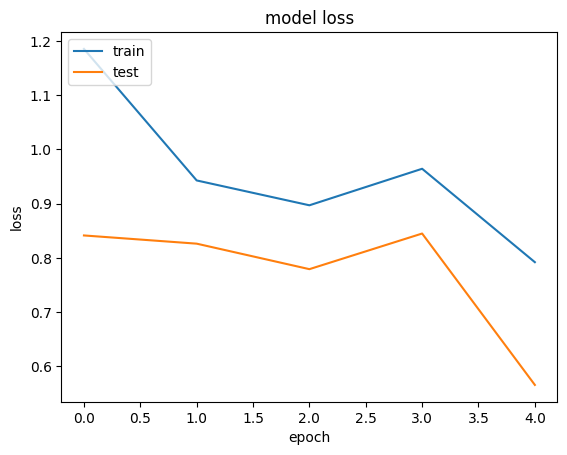

In [32]:
# plot epoch vs. loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

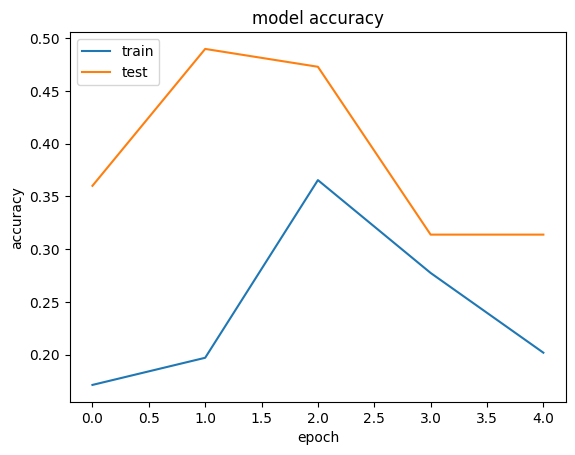

In [35]:
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [36]:
train_result = tf_model.predict(tf_train)

2023-09-14 15:56:45.235245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 96s 215ms/step


In [41]:
train_result["logits"]

array([[ 0.36753726,  0.13375124,  0.35738298, ...,  0.26621944,
        -0.31876543, -0.1921511 ],
       [ 0.37230408,  0.13671456,  0.36384183, ...,  0.26869953,
        -0.30881634, -0.18493618],
       [ 0.37288132,  0.11610243,  0.33263418, ...,  0.23628826,
        -0.35212094, -0.19835423],
       ...,
       [ 0.34684488,  0.11419833,  0.33451512, ...,  0.26386574,
        -0.30520546, -0.17280379],
       [ 0.35349524,  0.15075082,  0.33478868, ...,  0.27678666,
        -0.34026706, -0.17001504],
       [ 0.3543995 ,  0.11725996,  0.34397087, ...,  0.27524072,
        -0.30015218, -0.17669582]], dtype=float32)

# Model Training III: TensorFlow with pre-trained BERT

reference: https://github.com/huggingface/transformers/issues/1465

In [74]:
class TFBertForMultilabelClassification(TFBertPreTrainedModel):

    def __init__(self, config, *inputs, **kwargs):
        super(TFBertForMultilabelClassification, self).__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels

        self.bert = TFBertMainLayer(config, name='bert')
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels,
                                                # kernel_initializer=get_initializer(config.initializer_range),
                                                name='classifier',
                                                activation='sigmoid')

    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output, training=kwargs.get('training', False))
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        return outputs  # logits, (hidden_states), (attentions)

In [72]:
from transformers import TFBertPreTrainedModel, TFBertMainLayer, TFBertModel

class TFBertForMultilabelClassification(TFBertPreTrainedModel):

    def __init__(self, config, *inputs, **kwargs):
        super(TFBertForMultilabelClassification, self).__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels

        # self.bert = TFBertMainLayer(config, name="bert")
        self.bert = TFBertModel.from_pretrained(model_id).layers[0]
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels,
                                                # kernel_initializer=get_initializer(config.initializer_range),
                                                name="classifier",
                                                activation="sigmoid")

    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
        logits = self.classifier(pooled_output)
        outputs = (logits, ) + output[2:]

        return outputs # logits, (hidden_states), (attentions)
    

In [75]:
tf_model2 = TFBertForMultilabelClassification.from_pretrained(model_id, num_labels=num_labels)

ValueError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).

You have to specify either input_ids or inputs_embeds

Call arguments received by layer 'bert' (type TFBertMainLayer):
  • input_ids={}
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [ ]:
# prepare training: instantiate optimizer, loss and learning rate schedule 
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5) # using legacy optimizer on M1/M2 MBP
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()

tf_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])